# Tutorial 3: MT for Low-Resource Languages

So far, we've learnt (a) Units of Transformers and (b) How we can train pretrained tranformer architectures for our target languages. Now let's Zoom into our context: We want to make translation systems for LRL. This demands that we resolve several unique challenges. 


In this tutorial, we will cover methods that are of practical relevance to such class of languages. The choice of using these tricks or adaptations depends on **at least** 2 factors: The amount of source language and target langauge data. 





Let's look at how these choices vary exactly. If we have _paired_ and _large quantities (>1M)_ of data - We can simply ** train a model from scratch** to do translation. But oftentimes data in the practical world does not exist as language paired content and hence, it has to be aligned to create translation datasets. 

In [3]:
!pip install wikipedia
!pip install seaborn
!pip install transformers --quiet
!pip install sentence_transformers
!pip install indic-nlp-library


In [2]:
import wikipedia
import re
from sentence_transformers import SentenceTransformer
from transformers import MarianTokenizer, MarianMTModel
from indicnlp.transliterate.unicode_transliterate import UnicodeIndicTransliterator
from scipy.spatial import distance
import scipy
import numpy as np
import seaborn as sns

ModuleNotFoundError: No module named 'indicnlp'

## Helper Functions

In [ ]:
def translate_sentence(model, tokenizer, sample):
  batch = tokenizer(sample, return_tensors = 'pt')
  pred = model.generate(input_ids = batch['input_ids'])
  output = tokenizer.decode(pred[0], skip_special_tokens = True)
  return output

In [ ]:
def lexicon_translate(sample, lexicon):
  tokens = sample.split(' ')
  print(tokens)
  translation = ''
  for token in tokens:
    if token in lexicon: 
      translation += lexicon[token]
      translation += ' '
    else: 
      translation += '<unk> '
  return translation 

In [ ]:
def script_convert(src_lang, tgt_lang, sample):
    return UnicodeIndicTransliterator.transliterate(sample, src_lang, tgt_lang)

## Part 1: Alignment 

In [ ]:
wikipedia.set_lang('en')
en = wikipedia.summary('Sharukh Khan', sentences = 4)

In [ ]:
print(en)

Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi films. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 90 films, and earned numerous accolades, including 14 Filmfare Awards. He has been awarded the Padma Shri by the Government of India, as well as the Ordre des Arts et des Lettres and Legion of Honour by the Government of France. Khan has a significant following in Asia and the Indian diaspora worldwide.


In [ ]:
wikipedia.set_lang('hi')
hi = wikipedia.summary('Sharukh Khan', sentences = 1)

In [ ]:
en_lines, hi_lines = en.split('.'), hi.split('।')[:10]
print(f'The number of unpaired sentences across English are {len(en_lines)} and in Hindi are {len(hi_lines)}')

The number of unpaired sentences across English are 5 and in Hindi are 10


1. As you can see - there is no 1-1 correspondance between the source and target sentence pairs. [SWIFT](https://www.lrec-conf.org/proceedings/lrec2014/pdf/510_Paper.pdf), [Bleualign](https://github.com/rsennrich/Bleualign) and [HunAlign](https://github.com/danielvarga/hunalign) are examples of rule-based alignment tools but these are limited by the languages they can be applied to. So here we explore the State of the Art method. 




This involves an NLU Model - Which is tasked with creating a semantic representation of the sentences you have on either sides. Since the primary requirement of a valid translation pair is to preserve meaning - this NLU model is tasked with generating "meaning-preserving representations" across each language. 


In [ ]:
model = SentenceTransformer('LaBSE')

In [ ]:
source_embeddings = model.encode(en_lines,show_progress_bar=True)
target_embeddings = model.encode(hi_lines,show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Now let's try and see which sentence aligns best with which sentence
similarity = []
src_index_iter = 0
for source in source_embeddings:
  scores = []
  tgt_index_iter = 0
  for target in target_embeddings:
    distances = distance.cdist([source], [target], "cosine")[0]
    min_index = np.argmin(distances)
    sim = 1 - distances[min_index]
    tgt_index_iter += 1
    scores.append(sim) 
  src_index_iter += 1
  similarity.append(scores) 

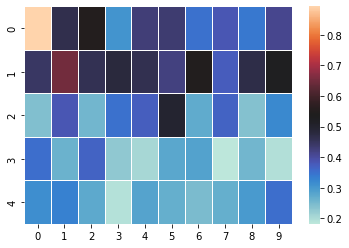

In [ ]:
sns.heatmap(similarity, linewidth=.5, cmap = 'icefire', linecolor = 'white')
sns.set_theme(style='whitegrid', 
              rc={'figure.dpi': 150})

Pay close to the 2nd and 5th sentences in English and Hindi respectively - a non one-one mapping which has been mined through such embedding-space matching. 

In [ ]:
print(en_lines[0])
print(hi_lines[0])

Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi films
शाहरुख़ ख़ान (उच्चारण [ʃɑːɦɾʊx xɑːn]; जन्म 2 नवम्बर 1965), जिन्हें अक्सर  शाह रुख़ ख़ान के रूप में श्रेय दिया जाता है और अनौपचारिक रूप में एसार्के नाम से सन्दर्भित किया जाता, एक भारतीय फ़िल्म अभिनेता है



As you can see, such alignment techniques can be scaled to create "weakly" parallel translation datasets. Depending on the amount of unlabelled data you have access to - we can vary the threshold of similarity and get different qualities of datasets.

## Part 2: Back-Translation

Another very effective method to augment LRL data relies on having large amount of data in the target language. Let's revisit our marian class models. 

In [ ]:
en_hi_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-hi')
hi_en_model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-hi-en')
en_hi_tok = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-hi')
hi_en_tok = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-hi-en')


/usr/local/lib/python3.9/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
# Paraphrased Back-Translation 

input = "While I was going to the market place, I saw a man riding a bicycle."
translation = translate_sentence(en_hi_model, en_hi_tok, input) 
print(translation)


# Let's reverse translate this 

back_translated_input = translate_sentence(hi_en_model, hi_en_tok, translation)
print(back_translated_input)
# Back-Translation for Unlabelled Data 

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


जब मैं बाज़ार जा रहा था, तो मैंने देखा कि एक आदमी साइकिल पर सफर कर रहा है ।
As I went to the market, I saw a man traveling on a bicycle.


Notice that even though the backtranslated input is not an exact replica of the input we provided, it is still a useful paraphrasing of the sample we provided. Technically, we now have two translation pairs against this sample: 


```
(input, translation) and (input, back_translated_input)
```



Also note that you could have used this method to generate translation pairs if you had unbalanced data in either of the languages. The only caveat there would be that you'd need a translation model to do this - and empirically it has been shown that LRL-HRL models perform much better ( _Can you guess why ?_ ) so this technique is often used to generate translation pairs when we have access to unlabelled LRL data and we need to generate a parallel translation corpus.  

## Part 3: Lexicon-Adaptation 

The methods demonstrated above, still assume the existence of unlabelled data for at least one of the languages. What about languages that do not have any unlabelled data as well ? (Can you think of languages like that ?)

In such scenarios, one surprisingly effective technique is a lexicon-replacement. Particularly, doing a word-word replacement in the source sentence using a source-target dictionary. This method is called lexicon-adaptation. 

In [ ]:
!wget https://raw.githubusercontent.com/kabirahuja2431/PracticalNLPLLMs/main/assets/toy_dict.csv

--2023-03-09 12:28:43--  https://raw.githubusercontent.com/kabirahuja2431/PracticalNLPLLMs/main/assets/toy_dict.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1770 (1.7K) [text/plain]
Saving to: ‘toy_dict.csv’

toy_dict.csv        100%[===================>]   1.73K  --.-KB/s    in 0s      

2023-03-09 12:28:43 (21.8 MB/s) - ‘toy_dict.csv’ saved [1770/1770]



In [ ]:
import csv 
lexicon = {}
with open('/content/toy_dict.csv') as file: 
  reader = csv.reader(file)
  for row in reader:
    lexicon[row[0]] = row[1]

In [ ]:
sample = "I have bought new clothes this year ."
translation = lexicon_translate(sample, lexicon)
print(translation)

['I', 'have', 'bought', 'new', 'clothes', 'this', 'year', '.']
मैं पास <unk> नया <unk> यह वर्ष <unk> 


Can you think of problems with this methods ? Consider the sentence "Rose went to the Market to pick up some grapes." :-) Despite its demerits, LA has been shown to provide meaningful initializations to pre-trained models against unseen languages. You can read more about them in [this](https://aclanthology.org/2022.acl-long.61.pdf) paper.  

## Part 4: Is Data Enough ?

In the previous sections, you saw a few methods to circumvent the data bottleneck in LRL. Let's assume that for any language in this world - you are able to circumvent this bottleneck. What next ? Is NLP for LRL resolved ? Lets see this with an example

In [ ]:
from transformers import MT5ForConditionalGeneration, T5Tokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('google/mt5-small')

In [ ]:
sentences = ['This is a test sample on which we will see the differences in tokenization.', 'यह एक परीक्षण नमूना है जिस पर हम टोकननाइजेशन में अंतर देखेंगे।', 'ଏହା ଏକ ପରୀକ୍ଷଣ ନମୁନା ଯାହା ଉପରେ ଆମେ ଟୋକେନାଇଜେସନ୍ରେ ପାର୍ଥକ୍ୟ ଦେଖିବା |']
for sentence in sentences:  print(len(tokenizer.encode(sentence)))



21
28
56


Notice how poorly the tokenizer deals with a language like Odia. This behaviour can primarily be attributed to the fact that the tokenizer has not seen this language and is hence, not able to produce meaningful representations for it. ## Let's see if we can try and mould this towards our liking: Hindi tokenizations appears to be decently performant.

In [ ]:

sc_sentence = script_convert('or', 'hi', sentences[2])
print(sentences[2])
print(sc_sentence)
print(f'{len(tokenizer.encode(sentences[2]))} is the length of the native script sentence.')
print(f'{len(tokenizer.encode(sc_sentence))} is the length of the script converted sentence.')



ଏହା ଏକ ପରୀକ୍ଷଣ ନମୁନା ଯାହା ଉପରେ ଆମେ ଟୋକେନାଇଜେସନ୍ରେ ପାର୍ଥକ୍ୟ ଦେଖିବା |
एहा एक परीक्षण नमुना याहा उपरे आमे टोकेनाइजेसन्रे पार्थक्य़ देखिबा |
56 is the length of the native script sentence.
29 is the length of the script converted sentence.


Can you think of other problems that might still be a bottleneck to using these models ? Consider - [mt5-large](https://huggingface.co/google/mt5-large) is 4.92 GB and [mt5-xxl](https://huggingface.co/google/mt5-xxl/tree/main) is 51.7 GB. Do you think such a model is deployable ?

Compression of LLMs is imperative to make such systems usable on low-capacity devices. One way this can be achieved is by _quantizing_ the model i.e., reducing the precision in which we store the model. 


So from fp32 ==> int8 and effectively you get a 4x reduction in size. 


If you need even more control over your shallow model's architecture - You can _distill_ these larger models. 

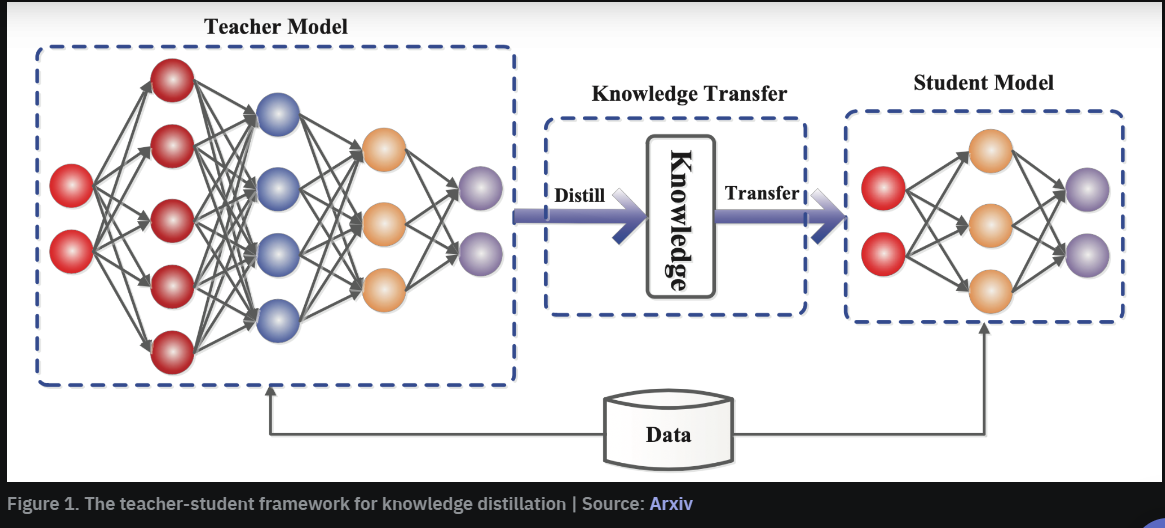

## Part 5: Conclusion
Working on Low-Resource Languages often involves using one or more of these techniques to build usable systems. Interestingly, different languages across the globe will require you to choose amongst these techniques. For eg: 
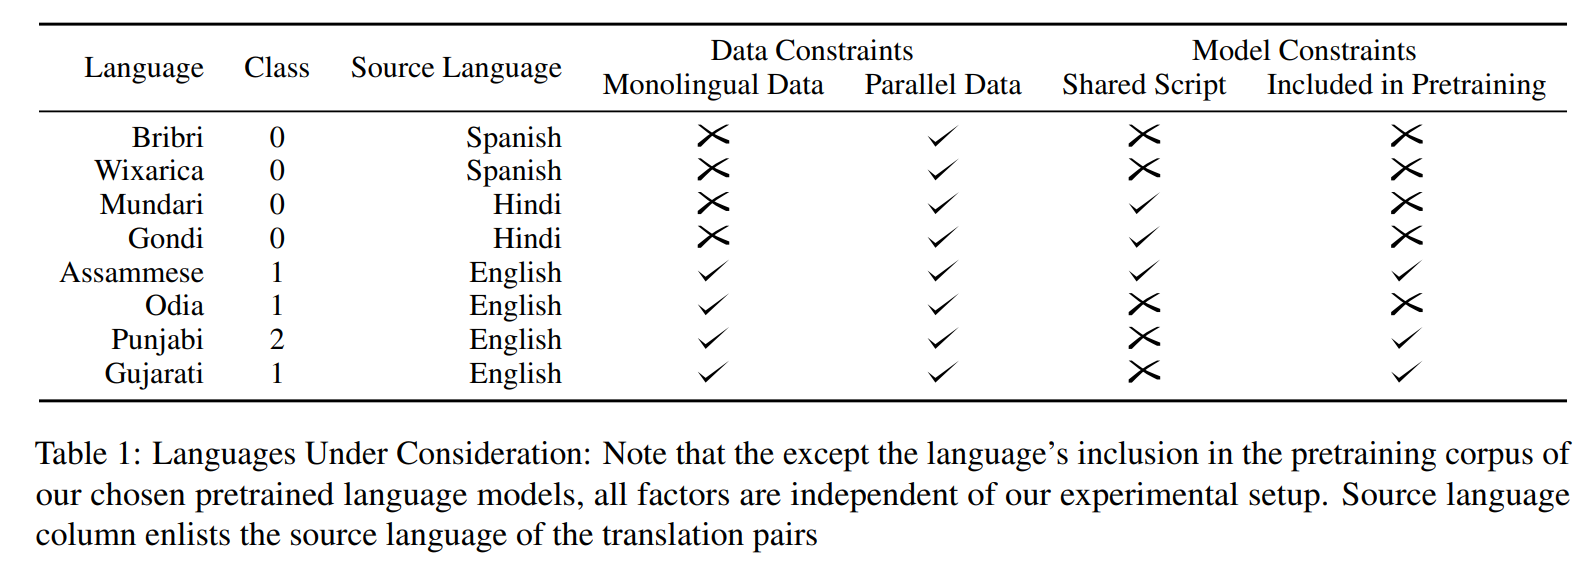
In each of these languages - you can adopt a different method; 

You can read more about this [here](https://aclanthology.org/2022.wmt-1.80.pdf), where we also discuss a bunch of caveats of generating lightweight models in these languages. 

## Part 6: Home Work


1.   **[Mining through Alignment]** [IndicCorp](https://ai4bharat.iitm.ac.in/corpora) is the largest indic monlingual corpus across indian languages. Choose a 50K subset of this dataset in 2 languages of your choice, and use LaBSE to mine a translation dataset for that language. Note your observations about verying the threshold of similarity.  
2.   **[Back Translation]** Generate 3 paraphrased versions of 500 sentences sampled from indic-corp. You cannot cascade the translations to do this - explore how "multiple inferences can be generated in a single pass" [Hint: Look up the definition of model.generate() and search up the "num_return_sequences" parameter or read through [this](https://huggingface.co/blog/how-to-generate)]

